<h1>Introduction</h1>


The aim of this project was to perform sentiment analysis on a collection of movie reviews sourced from the IMDb movie review site, in order to automatically classify each review in the dataset as either positive or negative.

Our group performed a series of experiments leveraging a range of natural language processing (NLP) techniques to determine the process which would yield the highest performance (in this case, measured by validation accuracy and loss) when classifying reviews in the dataset.

In a general sense, the findings of this project may be applicable in industry for the purpose of automatically producing meaningful statistical metrics about a set of user-submitted text. These metrics would describe the presiding sentiment of a large set of such submissions, and may be used by a company to inform decisions about their user base, or provide users with context regarding the opinions of other users.

For instance, these techniques could be applied to the analysis of reviews for products in an online retail space, allowing the company to better determine which products are most popular (user-submitted quantitative ratings, e.g. stars, may be unreliable), or providing prospective customers more detailed information about the opinions of owners of the product.








# Imports and global variables

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import textwrap
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
import spacy
from torchtext.vocab import GloVe, FastText
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from IPython.display import display, Markdown, HTML

In [ ]:
# Download core english lemmatisation database
!python -m spacy download en_core_web_sm
spacy_nlp = spacy.load('en_core_web_sm')

In [ ]:
# Download nltk english stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erich\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# NOTE: Modify this path to point to the desired directory for caching data and model files
PATH = ''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_REVIEW_LENGTH = 150
BATCH_SIZE = 64

# Data sources

Link to kaggle competition: https://www.kaggle.com/competitions/word2vec-nlp-tutorial/overview

Accessing the database requires agreeing to the competition rules. Once accepted, database can be downloaded and extracted to running instance.

Before continuing please download labeledTrainData.tsv to root from the extracted ZIP file.



# Exploratory data analysis

Following steps are performed before further exploring the dataset

*   Remove HTML tags
*   Remove all non-letters
*   Convert text to lowercase


labeledTrainData shape: (25000, 3)
labeledTrainData column values: ['id' 'sentiment' 'review']
labeledTrainData first element:
review text:
"With all this stuff going down at the moment with MJ i've started listening to his music, watching
the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want
to get a certain insight into this guy who i thought was really cool in the eighties just to maybe
make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film
which i remember going to see at the cinema when it was originally released. Some of it has subtle
messages about MJ's feeling towards the press and also the obvious message of drugs are bad
m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you
remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an
egotist for consenting to the making of this movie BUT MJ and most of his

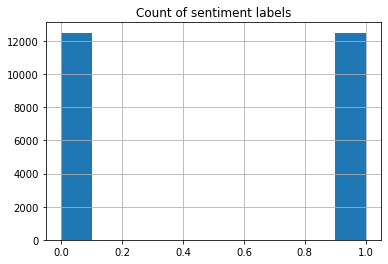

converting review of first element to wordlist:
with all this stuff going down at the moment with mj i ve started listening to his music watching
the odd documentary here and there watched the wiz and watched moonwalker again maybe i just want to
get a certain insight into this guy who i thought was really cool in the eighties just to maybe make
up my mind whether he is guilty or innocent moonwalker is part biography part feature film which i
remember going to see at the cinema when it was originally released some of it has subtle messages
about mj s feeling towards the press and also the obvious message of drugs are bad m kay visually
impressive but of course this is all about michael jackson so unless you remotely like mj in anyway
then you are going to hate this and find it boring some may call mj an egotist for consenting to the
making of this movie but mj and most of his fans would say that he made it for the fans which if
true is really nice of him the actual feature film bit whe

C:\Users\erich\anaconda3\envs\yolov7\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [ ]:
labeledTrainData = pd.read_csv(PATH + "labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
print('labeledTrainData shape:', labeledTrainData.shape)
print('labeledTrainData column values:', labeledTrainData.columns.values)

print('labeledTrainData first element:')
print('review text:')
print(textwrap.fill(labeledTrainData['review'][0], 100))
print('sentiment: ', labeledTrainData['sentiment'][0])

print('Count of sentiment labels:')
print(labeledTrainData['sentiment'].value_counts())
labeledTrainData['sentiment'].hist()
plt.title('Count of sentiment labels')
plt.show()

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    labeledTrainData['review'], labeledTrainData['sentiment'], test_size=test_size, random_state=0)

# Convert from series to dataframe to store the processedreview column
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)


def review_to_wordlist(review, remove_stopwords=False, lemmatise=False):
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()

    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)

    # 3. Convert words to lower case and split them
    words = review_text.lower().split()

    # 4. Optionally remove stop words (false by default, always remove if using BERT tokenisation)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    # 5. Optionally lemmatise (false by default, always lemmatise if using BERT tokenisation)
    if lemmatise:
        review_text = ' '.join(words)
        review_spacy = spacy_nlp(review_text)
        words = [token.lemma_ for token in review_spacy]

    # 6. Return a list of words
    return(words)


def process_review(review):
    return ' '.join(review_to_wordlist(review))


# example with first review
# textwrap.fill is for making the formatting of strings better when using print()
print('converting review of first element to wordlist:')
print(textwrap.fill(' '.join(review_to_wordlist(labeledTrainData['review'][0])), 100))

# Using function above to process all the training data for further exploration:
X_train['ProcessedReview'] = ""
X_train['ProcessedReview'] = X_train['review'].apply(process_review)

Now we explore the data to get a general overview

In [ ]:
# Get info about a dataframe containing pre-processed review text e.g. vocab size, words by frequency
def get_word_info(df):
  word_info = dict()
  word_counts = dict()
  review_lengths = []


  for review in df['ProcessedReview']:
    words = review.split(' ')
    review_lengths.append(len(words))
    for word in words:
      if word in word_counts:
        word_counts[word] += 1
      else:
        word_counts[word] = 1

  word_info['word_counts'] = word_counts
  word_info['max_review_length'] = max(review_lengths)
  word_info['review_lengths'] = review_lengths
  word_info['average_review_length'] = sum(review_lengths) / len(review_lengths)

  word_info['review_count'] = df.shape[0]
  word_info['vocab_size'] = len(word_counts)
  word_info['total_word_count'] = sum(word_counts.values())

  word_info['freq_words'], word_info['infreq_words'] = get_most_and_least_freq_words(word_counts, 100)
  return word_info

# Given a dictionary of words by frequency, return two lists containing the {num_words} most and least frequent words respectively
def get_most_and_least_freq_words(word_count_dict, num_words):
  # list of {num_words} most frequent words in all reviews - can use for word bubble?
  freq_words = []
  count = 0

  num_words_to_get = min(num_words, len(word_count_dict))

  for word in sorted(word_count_dict, key=word_count_dict.get, reverse=True):
    if count == num_words_to_get:
      break
    freq_words.append(word)
    count += 1

  # list of {num_words} least frequent words in all reviews - can use for word bubble?
  count = 0
  infreq_words = []

  for word in sorted(word_count_dict, key=word_count_dict.get):
    if count == num_words_to_get:
      break
    infreq_words.append(word)
    count += 1

  return (freq_words, infreq_words)

# Print info about a set of review text data e.g. vocab size, words by frequency, from a pre-built dictionary
def print_word_info(word_info):
  # number of different words (size of vocab)
  print("Size of vocab: " + str(word_info['vocab_size']))

  # Max review length across all reviews
  print("Max review length count across all reviews: " + str(word_info['max_review_length']))

  # Average review length across all reviews
  print("Average review length count across all reviews: " + str(word_info['average_review_length']))

  # number of total words across all reviews (with duplicates)
  print("Number of total words across all reviews: " + str(word_info['total_word_count']))

  print("Number of reviews: " + str(word_info['review_count']))

  # list of 100 most frequent words in all reviews - can use for word bubble?
  print("100 most frequent words:")
  print(word_info['freq_words'])

  # list of 100 least frequent words in all reviews - can use for word bubble?
  print("100 least frequent words:")
  print(word_info['infreq_words'])

  if 'freq_unique_words' in word_info:
    print(f"{len(word_info['freq_unique_words'])} most frequent unique words:")
    print(word_info['freq_unique_words'])

  if 'infreq_unique_words' in word_info:
    print(f"{len(word_info['infreq_unique_words'])} least frequent unique words:")
    print(word_info['infreq_unique_words'])


# Extract separate dataframes containing positive and negative reviews from the training data
# Get indices of positive reviews (need to reset indices on y_train since it retains indices from original 25,000 item dataframe)
positive_indices = y_train.reset_index().index[y_train == 1].tolist()

print(f"Type: {type(y_train[0])}" )

# Get positive reviews from set of all reviews using indices
positive_reviews = X_train.iloc[positive_indices]

# Get indices of negative reviews (need to reset indices on y_train since it retains indices from original 25,000 item dataframe)
negative_indices = y_train.reset_index().index[y_train == 0].tolist()

# Get positive reviews from set of all reviews using indices
negative_reviews = X_train.iloc[negative_indices]

positive_word_info = get_word_info(positive_reviews)
negative_word_info = get_word_info(negative_reviews)

# Get unique words in both positive and negative review data (non-shared words)
positive_word_info['unique_word_counts'] = positive_word_info['word_counts'].copy()
negative_word_info['unique_word_counts'] = negative_word_info['word_counts'].copy()
for word in positive_word_info['word_counts']:
  if word in negative_word_info['word_counts']:
    positive_word_info['unique_word_counts'].pop(word)
    negative_word_info['unique_word_counts'].pop(word)

positive_word_info['freq_unique_words'], positive_word_info['infreq_unique_words'] = get_most_and_least_freq_words(positive_word_info['unique_word_counts'], 100)
negative_word_info['freq_unique_words'], negative_word_info['infreq_unique_words'] = get_most_and_least_freq_words(negative_word_info['unique_word_counts'], 100)

print("*** All the following applies for the training set only***\n")
print("--- Analysis of All Reviews ---")
word_info = get_word_info(X_train)
print_word_info(word_info)

print("--- Analysis of Reviews with Positive Sentiment ---")
print_word_info(positive_word_info)

print("--- Analysis of Reviews with Negative Sentiment ---")
print_word_info(negative_word_info)


Type: <class 'numpy.int64'>
*** All the following applies for the training set only***

--- Analysis of All Reviews ---
Size of vocab: 67774
Max review length count across all reviews: 2487
Average review length count across all reviews: 237.6446
Number of total words across all reviews: 4752892
Number of reviews: 20000
100 most frequent words:
['the', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 't', 'you', 'on', 'not', 'he', 'his', 'are', 'have', 'be', 'one', 'all', 'at', 'they', 'by', 'an', 'who', 'so', 'from', 'like', 'there', 'her', 'or', 'just', 'about', 'out', 'has', 'if', 'what', 'some', 'good', 'can', 'more', 'she', 'when', 'very', 'up', 'my', 'time', 'even', 'no', 'would', 'which', 'only', 'story', 'really', 'see', 'had', 'their', 'we', 'me', 'well', 'were', 'than', 'much', 'been', 'get', 'will', 'bad', 'people', 'also', 'other', 'do', 'great', 'because', 'into', 'first', 'how', 'him', 'don', 'most', '

# Models and methods

We initially preprocessed the data to make it more friendly for feeding into the neural network. In addition, we also experimented with different types of word embeddings and network architectures and mixed implementations to compare how that would affect model perforrmance.

## Preprocessing

Now additionally applying removing stopwords and lemmatisation to review texts.

In [ ]:
X_train['ProcessedReview'] = X_train['review'].apply(lambda review: review_to_wordlist(review, remove_stopwords=True, lemmatise=True))
X_test['ProcessedReview'] = X_test['review'].apply(lambda review: review_to_wordlist(review, remove_stopwords=True, lemmatise=True))

## Word embeddings
Code for our 4 word embedding methods.

If the embeddings already exist, they are loaded in to save time. Otherwise, they are created from scratch and then saved.

**Note: only one of the four below cells should be run during a given experiment, as they provide equivalent, interchangeable functionality.**


### Glove

In [ ]:
EMBED_LEN = 300

# import from torchtext
global_vectors = None

vocab_path = PATH + 'glove.840B.300d.pth'

if os.path.exists(vocab_path):
  global_vectors = torch.load(vocab_path)
else:
  global_vectors = GloVe(name='840B', dim=EMBED_LEN)
  torch.save(global_vectors, vocab_path)

# ReviewDataset class for processing pre-processed input text into GloVe embeddings to be input to the classification network
class ReviewDataset(Dataset):
  def __init__(self, reviews, sentiments):
    # For each review, add filler (empty) strings to the list of tokenised words if it is shorter than MAX_REVIEW_LENGTH
    padded_reviews = [tokens + [""] * (MAX_REVIEW_LENGTH-len(tokens)) if len(tokens)<MAX_REVIEW_LENGTH else tokens[:MAX_REVIEW_LENGTH] for tokens in reviews]
    reviews_tensor = torch.zeros(len(reviews), MAX_REVIEW_LENGTH, EMBED_LEN)

    # Convert token list to list of word vectors
    for i, tokens in enumerate(padded_reviews):
        reviews_tensor[i] = global_vectors.get_vecs_by_tokens(tokens)
    self.x = reviews_tensor

    y_tensor = torch.tensor(sentiments.values, dtype=torch.float32)
    self.y = y_tensor.reshape(y_tensor.shape[0], -1)

  def __len__(self):
    return len(self.y)
  def __getitem__(self,idx):
    return self.x[idx], self.y[idx]

### Word2vec

In [ ]:
# import from torchtext
global_vectors = None

vocab_path = PATH + VOCAB_FILE

if os.path.exists(vocab_path):
  global_vectors = torch.load(vocab_path)
else:
  global_vectors = CharNGram()
  torch.save(global_vectors, vocab_path)

class ReviewDataset(Dataset):
  def __init__(self, reviews, sentiments):
    # For each review, add filler (empty) strings to the list of tokenised words if it is shorter than MAX_REVIEW_LENGTH
    padded_reviews = [tokens + [""] * (MAX_REVIEW_LENGTH-len(tokens)) if len(tokens)<MAX_REVIEW_LENGTH else tokens[:MAX_REVIEW_LENGTH] for tokens in reviews]
    reviews_tensor = torch.zeros(len(reviews), MAX_REVIEW_LENGTH * EMBED_LEN)

    # Convert token list to list of word vectors
    for i, tokens in enumerate(padded_reviews):
        reviews_tensor[i] = global_vectors.get_vecs_by_tokens(tokens).flatten()
    self.x = reviews_tensor

    y_tensor = torch.tensor(sentiments.values, dtype=torch.float32)
    self.y = y_tensor.reshape(y_tensor.shape[0], -1)

  def __len__(self):
    return len(self.y)
  def __getitem__(self,idx):
    return self.x[idx], self.y[idx]

### Fasttext

In [ ]:
EMBED_LEN = 300

VOCAB_FILE = 'ft.cc.en.300.bin'

global_vectors = None

vocab_path = PATH + VOCAB_FILE

if os.path.exists(vocab_path):
  global_vectors = torch.load(vocab_path)
else:
  global_vectors = FastText('simple')
  torch.save(global_vectors, vocab_path)

class ReviewDataset(Dataset):
  def __init__(self, reviews, sentiments):
    # For each review, add filler (empty) strings to the list of tokenised words if it is shorter than MAX_REVIEW_LENGTH
    padded_reviews = [tokens + [""] * (MAX_REVIEW_LENGTH-len(tokens)) if len(tokens)<MAX_REVIEW_LENGTH else tokens[:MAX_REVIEW_LENGTH] for tokens in reviews]
    reviews_tensor = torch.zeros(len(reviews), MAX_REVIEW_LENGTH * EMBED_LEN)

    # Convert token list to list of word vectors
    for i, tokens in enumerate(padded_reviews):
        reviews_tensor[i] = global_vectors.get_vecs_by_tokens(tokens).flatten()
    self.x = reviews_tensor

    y_tensor = torch.tensor(sentiments.values, dtype=torch.float32)
    self.y = y_tensor.reshape(y_tensor.shape[0], -1)

  def __len__(self):
    return len(self.y)
  def __getitem__(self,idx):
    return self.x[idx], self.y[idx]

### BERT

In [ ]:
# Code referenced from Pytorch Docs: https://pytorch.org/hub/huggingface_pytorch-transformers/
# Also referenced from: https://towardsdatascience.com/3-types-of-contextualized-word-embeddings-from-bert-using-transfer-learning-81fcefe3fe6d
bert_tokeniser_path = PATH + 'BERT/tokeniser/'
bert_path = PATH + 'BERT/model/'

bert_tokeniser = None
bert = None

bert_tokeniser = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

bert = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True,)

def bert_tokenise(review_words):
    # Tokeniser code derived from: https://towardsdatascience.com/3-types-of-contextualized-word-embeddings-from-bert-using-transfer-learning-81fcefe3fe6d
    # Encode words using BERT tokeniser (BERT requires special tokenised input which includes start, end and separator tokens etc.)
    tokens = bert_tokeniser.tokenize(' '.join(review_words),
                                      truncation=True,              # Truncate token list to the specified max length
                                      max_length=MAX_REVIEW_LENGTH, # Max length should be the specified max review length
                                      add_special_tokens=True,      # Automatically insert special tokens required for BERT input
                                      padding='max_length')         # Pad reviews which are shorter than the max length with empty tokens, to reach the max length
    token_ids = bert_tokeniser.convert_tokens_to_ids(tokens)

    return token_ids

X_train['ProcessedReview'] = X_train['review'].apply(lambda words: bert_tokenise(words))

# ReviewDataset class for processing BERT-tokenised input text into BERT embeddings to be input to the classification network
class ReviewDataset(Dataset):
  def __init__(self, reviews, sentiments):
    # BERT code derived from: https://towardsdatascience.com/3-types-of-contextualized-word-embeddings-from-bert-using-transfer-learning-81fcefe3fe6d

    # Convert token list to list of embeddings using BERT
    segments_tensor = torch.tensor([[1]*MAX_REVIEW_LENGTH])

    # BERT embedding batch size, may need to decrease this value to ~2000 if using free Colab tier
    batch_size = 2500

    states_tensor = torch.empty((0, MAX_REVIEW_LENGTH, EMBED_LEN), dtype=torch.int64)
    num_batches = int(len(reviews) / batch_size)

    print("Converting review dataframe to dataset...")

    # Split processing of BERT embeddings into several batches to avoid exceeding memory limits
    with torch.no_grad():
      for i in range(0, len(reviews), batch_size):
        batch_num = int(i/batch_size) + 1
        print(f"Processing batch {batch_num}/{num_batches}...")
        batch = bert(torch.tensor(reviews.values[i : i + batch_size].tolist(), dtype=torch.int), segments_tensor)
        # torch.save(batch[2][1:][-1], PATH + f"BERT/embeddings/batch{batch_num}.pt")
        states_tensor = torch.cat([states_tensor, batch[2][1:][-1]])
        print(f"\tFinished batch {batch_num}/{num_batches}!")

    print("Finished processing all batches!")

    self.x = states_tensor

    y_tensor = torch.tensor(sentiments.values, dtype=torch.float32)
    self.y = y_tensor.reshape(y_tensor.shape[0], -1)

  def __len__(self):
    return len(self.y)
  def __getitem__(self,idx):
    return self.x[idx], self.y[idx]

## Building the dataset loader

This is used for combining a dataset and a sampler which provides a mechanism for iterating over the dataset.

In [ ]:
train_loader = DataLoader(ReviewDataset(X_train['ProcessedReview'], y_train), batch_size=BATCH_SIZE)
test_loader  = DataLoader(ReviewDataset(X_test['ProcessedReview'], y_test), batch_size=BATCH_SIZE)

## Neural network architectures

We used four main architectures: Linear, LSTM, GRU and CNN. All architectures used a *Sequential* which is a container for chaining outputs to inputs from one module to the next. This allows the whole container to be treated as a single module.



### Linear network architecture definition

The linear network architecture was the simplest architecture used and was used as the baseline model which we would make improvements upon. It consisted of 3 fully connected hidden linear layers along with using ReLU as the activation function and Sigmoid as the final activation function. After hyptertuning, it was discovered the parameters which produced the highest accuracy were hidden unit sizes of 1000,5000 and 250.

In [ ]:
class EmbeddingClassifier(nn.Module):
    def __init__(self):
        super(EmbeddingClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(EMBED_LEN*MAX_REVIEW_LENGTH, 1000),
            nn.ReLU(),

            nn.Linear(1000,500),
            nn.ReLU(),

            nn.Linear(500,250),
            nn.ReLU(),

            nn.Linear(250, 1),
            nn.Sigmoid()
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

### LSTM and BiLSTM network architecture definition

THe LSTM and Bi-LSTM are more complex architectures which were also used. The difference between the normal LSTM and Bi-LSTM is that the Bi-LSTM considers the review text in both the forwards and backwards directions.The LSTM imprvoes upno the normal RUNN architecture by being able too 'remember' features further in the past using its forget, input and output gates. Our approach was to take the word embeddings as input to the LSTM, feed each next word in the review as the input to subsequent cells, and retrieve the output of the final timestep to then be fed to a linear layer. After hypertuning, it was discovered that the best parameters for accuracy are 128 for the LSTM along with 2 linear layers with hidden unit sizes of 128 and 20 along with a dropout rate of 0.25 followed by 0.3 for the normal LSTM. The Bi-LSTM is similar but instead uses a hidden unit size of 256 instead of 128 for the linear layer.

In [ ]:
class extract_output_lstm(nn.Module):
    def forward(self,x):
        # Output shape (batch, max_review_length, hidden)
        output, _ = x
        return output[:, -1, :] # only want the output from last element in sequence

class extract_output_bilstm(nn.Module):
    def forward(self,x):
        # Output shape (batch, max_review_length, hidden * 2)
        output, _ = x
        fw = output[:, -1, :] # forward pass final timestep
        bw = output[:, 0, :] # backward pass final timestep
        # Now remove the unwanted concat values of forward and backward pass
        half = output.shape[2] // 2
        fw = fw[:, 0:half] # remove the backward pass values
        bw = bw[:, half:] # remove the forward pass values
        return torch.cat((fw, bw), 1) # concat forward and backward pass final timestep values

class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()
        lstm_hid_size = 128
        self.seq = nn.Sequential(
            #input size, hidden size (hyperparam), number of rnn layers to stack (hyperparam)
            nn.LSTM(EMBED_LEN, lstm_hid_size, 1, bidirectional=False, batch_first=True),
            extract_output_lstm(),

            nn.Dropout(p=0.25),
            nn.Linear(lstm_hid_size, 20),
            nn.ReLU(),

            nn.Dropout(p=0.3),
            nn.Linear(20, 1),
            nn.Sigmoid()
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

class BiLSTMClassifier(nn.Module):
    def __init__(self):
        super(BiLSTMClassifier, self).__init__()
        bilstm_hid_size = 128
        self.seq = nn.Sequential(
            #input size, hidden size (hyperparam), number of rnn layers to stack (hyperparam)
            nn.LSTM(EMBED_LEN, bilstm_hid_size, 1, bidirectional=True, batch_first=True),
            extract_output_bilstm(),

            nn.Dropout(p=0.25),
            nn.Linear(bilstm_hid_size * 2, 20),
            nn.ReLU(),

            nn.Dropout(p=0.3),
            nn.Linear(20, 1),
            nn.Sigmoid()
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

### GRU network architecture definition

The GRU can also be used to remember long-term dependencies but only utilises two gates (reset and update) compared to the LSTM's three gates.The architecture consisted of a GRU layer, followed by a fully connected linear layer and then the final output layer with a single node. After hypertuning, it was discovered that the best parameters for accuracy are 128 units in the GRU layer, 20 hidden units in the linear layer and 0.5 for the dropout.

In [ ]:
class extract_tensor(nn.Module):
    def forward(self,x):
        # Output shape (batch, features, hidden)
        tensor, _ = x
        return tensor[:, -1, :] # only want the output from last element in sequence

class GRUClassifier(nn.Module):
    def __init__(self):
        super(GRUClassifier, self).__init__()
        lstm_hid_size = 128
        self.seq = nn.Sequential(
            #input size, hidden size (hyperparam), number of rnn layers to stack (hyperparam)
            nn.GRU(EMBED_LEN, lstm_hid_size, 1, bidirectional=False, batch_first=True),
            extract_tensor(),

            nn.Dropout(p=0.5),
            nn.Linear(lstm_hid_size, 20),
            nn.ReLU(),

            nn.Dropout(p=0.2),
            nn.Linear(20, 1),
            nn.Sigmoid()
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

### CNN network architecture definition#

The final arhictecture used was the CNN. A review with a size of *word embedding length* by *review word length* is fed as the input, which imitates a 2D image but contains word embeddings instead of pixels. It consisted of a 2D convolutional layer, followed by a max pooling layer, a fully connected layer with dropout, and then the final output layer with one node. After hypertuning, the best parameters for accuracy were a filter size of 5, 10 filters, max pooling to be 2 and a dropout value of 0.3.

In [ ]:
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()

        self.FILTER_SIZE = 5
        self.NUMBER_FILTERS = 10
        self.POOLING_SIZE = 2

        self.convOps = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=self.NUMBER_FILTERS, kernel_size=self.FILTER_SIZE),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=self.POOLING_SIZE),
            torch.nn.Flatten())

        self.fullyconLayer = nn.Linear(108040, 1)
        self.dropout = nn.Dropout(p=0.5)
# groups=1, weight of size [101, 1, 4, 4], expected input[1, 50, 100, 300] to have 1 channels, but got 50 channels instead

    def forward(self, X_batch):
        X_batch = X_batch.unsqueeze(0)
        x_permuted = X_batch.permute(1, 0, 2, 3)

        conv = self.convOps(x_permuted)
        #convFix = nn.Flatten(conv)

        output_sum = self.fullyconLayer(conv)

        out = torch.sigmoid(output_sum)

        return out

## Model training and results

After defining the network architecture, the model was then trained for the chosen number of epochs. Training loss, validation loss and accuracy are plotted to compare each model with accuracy being the ultimate tool for evaluating model evaluation.



### Model training loop

In [ ]:
def CalcValLossAndAccuracy(model, loss_fn, val_loader, valid_losses, valid_accs, flatten=False):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            # Need to flatten X for linear
            if flatten:
                X = torch.reshape(X, (X.shape[0], X.shape[1] * X.shape[2]))

            X = X.to(device)
            Y = Y.to(device)

            preds = model(X)

            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            preds = (preds >= 0.5).float()

            Y_shuffled.append(Y)

            Y_preds.append(preds)

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        valid_loss = torch.tensor(losses).mean()
        valid_acc = accuracy_score(Y_shuffled.detach().cpu().numpy(), Y_preds.detach().cpu().numpy())
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        print("Valid Loss : {:.3f}".format(valid_loss))
        print("Valid Acc  : {:.3f}".format(valid_acc))


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, valid_losses, valid_accs, train_losses, epochs=10, flatten=False):
    for i in range(1, epochs+1):
        losses = []
        print('Epoch :', i)
        for X, Y in tqdm(train_loader):
            # Need to flatten X for linear
            if flatten:
                X = torch.reshape(X, (X.shape[0], X.shape[1] * X.shape[2]))

            X = X.to(device)
            Y = Y.to(device)

            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss = torch.tensor(losses).mean()
        train_losses.append(train_loss)

        print("Train Loss : {:.3f}".format(train_loss))
        CalcValLossAndAccuracy(model, loss_fn, val_loader, valid_losses, valid_accs, flatten)

def PlotOutput(values, y_label, epochs):
    time = list(range(1,epochs + 1))
    plt.plot(time,values)
    plt.xlabel("Epochs")
    plt.ylabel(y_label)
    plt.title("Comparing " + y_label + " over Time")
    # plt.savefig(y_label + "_over_time_graph.png")
    plt.show()

### Train Linear
##### A classifier is created along with a loss function (binary cross entropy is chosen here) and an optimiser (Adam is chosen here). The model is then trained using the aforementioned tools.

Epoch : 1


100%|█████████████████████████████████████████████████| 313/313 [00:06<00:00, 47.24it/s]


Train Loss : 0.598
Valid Loss : 0.465
Valid Acc  : 0.800
Epoch : 2


100%|█████████████████████████████████████████████████| 313/313 [00:05<00:00, 55.72it/s]


Train Loss : 0.365
Valid Loss : 0.430
Valid Acc  : 0.808
Epoch : 3


100%|█████████████████████████████████████████████████| 313/313 [00:05<00:00, 56.64it/s]


Train Loss : 0.228
Valid Loss : 0.486
Valid Acc  : 0.802
Epoch : 4


100%|█████████████████████████████████████████████████| 313/313 [00:05<00:00, 57.29it/s]


Train Loss : 0.126
Valid Loss : 0.579
Valid Acc  : 0.797
Epoch : 5


100%|█████████████████████████████████████████████████| 313/313 [00:05<00:00, 52.54it/s]


Train Loss : 0.067
Valid Loss : 0.624
Valid Acc  : 0.792
Epoch : 6


100%|█████████████████████████████████████████████████| 313/313 [00:05<00:00, 55.94it/s]


Train Loss : 0.039
Valid Loss : 0.734
Valid Acc  : 0.785
Epoch : 7


100%|█████████████████████████████████████████████████| 313/313 [00:05<00:00, 56.60it/s]


Train Loss : 0.023
Valid Loss : 0.771
Valid Acc  : 0.791
Epoch : 8


100%|█████████████████████████████████████████████████| 313/313 [00:05<00:00, 57.45it/s]


Train Loss : 0.013
Valid Loss : 0.840
Valid Acc  : 0.793
Epoch : 9


100%|█████████████████████████████████████████████████| 313/313 [00:05<00:00, 57.20it/s]


Train Loss : 0.007
Valid Loss : 0.892
Valid Acc  : 0.795
Epoch : 10


100%|█████████████████████████████████████████████████| 313/313 [00:05<00:00, 57.28it/s]


Train Loss : 0.004
Valid Loss : 0.950
Valid Acc  : 0.789


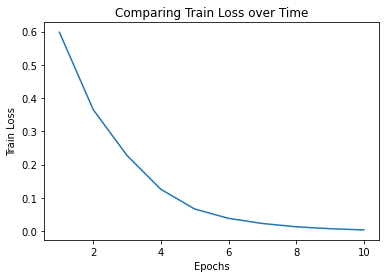

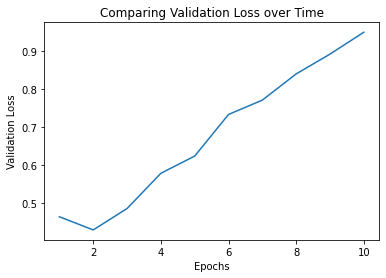

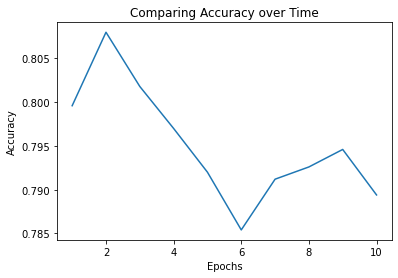

In [ ]:
embed_classifier = EmbeddingClassifier()

loss_fn = F.binary_cross_entropy
optimizer = Adam(embed_classifier.parameters(), lr=1e-5)

embed_classifier.to(device)

linear_valid_losses = []
linear_valid_accs = []
linear_train_losses = []
epochs = 10
TrainModel(embed_classifier, loss_fn, optimizer, train_loader, test_loader, linear_valid_losses, linear_valid_accs, linear_train_losses, epochs, flatten=True)
PlotOutput(linear_train_losses, 'Train Loss', epochs)
PlotOutput(linear_valid_losses, "Validation Loss", epochs)
PlotOutput(linear_valid_accs, "Accuracy", epochs)
# torch.save(embed_classifier, PATH + 'models/linear.model')

### Train LSTM

Epoch : 1


100%|█████████████████████████████████████████████████| 313/313 [00:04<00:00, 73.43it/s]


Train Loss : 0.691
Valid Loss : 0.695
Valid Acc  : 0.490
Epoch : 2


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.39it/s]


Train Loss : 0.693
Valid Loss : 0.694
Valid Acc  : 0.490
Epoch : 3


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 87.14it/s]


Train Loss : 0.693
Valid Loss : 0.693
Valid Acc  : 0.505
Epoch : 4


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 83.28it/s]


Train Loss : 0.693
Valid Loss : 0.691
Valid Acc  : 0.517
Epoch : 5


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 83.69it/s]


Train Loss : 0.631
Valid Loss : 0.604
Valid Acc  : 0.673
Epoch : 6


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 80.77it/s]


Train Loss : 0.632
Valid Loss : 0.687
Valid Acc  : 0.533
Epoch : 7


100%|█████████████████████████████████████████████████| 313/313 [00:04<00:00, 77.26it/s]


Train Loss : 0.650
Valid Loss : 0.585
Valid Acc  : 0.776
Epoch : 8


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 82.99it/s]


Train Loss : 0.602
Valid Loss : 0.626
Valid Acc  : 0.635
Epoch : 9


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 88.09it/s]


Train Loss : 0.573
Valid Loss : 0.509
Valid Acc  : 0.785
Epoch : 10


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.96it/s]


Train Loss : 0.609
Valid Loss : 0.651
Valid Acc  : 0.566
Epoch : 11


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 83.73it/s]


Train Loss : 0.505
Valid Loss : 0.477
Valid Acc  : 0.811
Epoch : 12


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 87.24it/s]


Train Loss : 0.460
Valid Loss : 0.442
Valid Acc  : 0.839
Epoch : 13


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 82.76it/s]


Train Loss : 0.567
Valid Loss : 0.465
Valid Acc  : 0.806
Epoch : 14


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 79.87it/s]


Train Loss : 0.435
Valid Loss : 0.406
Valid Acc  : 0.834
Epoch : 15


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 83.33it/s]


Train Loss : 0.376
Valid Loss : 0.366
Valid Acc  : 0.853
Epoch : 16


100%|█████████████████████████████████████████████████| 313/313 [00:04<00:00, 71.62it/s]


Train Loss : 0.341
Valid Loss : 0.363
Valid Acc  : 0.855
Epoch : 17


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.38it/s]


Train Loss : 0.322
Valid Loss : 0.372
Valid Acc  : 0.858
Epoch : 18


100%|█████████████████████████████████████████████████| 313/313 [00:04<00:00, 69.51it/s]


Train Loss : 0.303
Valid Loss : 0.353
Valid Acc  : 0.859
Epoch : 19


100%|█████████████████████████████████████████████████| 313/313 [00:04<00:00, 71.57it/s]


Train Loss : 0.269
Valid Loss : 0.358
Valid Acc  : 0.862
Epoch : 20


100%|█████████████████████████████████████████████████| 313/313 [00:04<00:00, 72.72it/s]


Train Loss : 0.237
Valid Loss : 0.378
Valid Acc  : 0.858
Epoch : 21


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 78.88it/s]


Train Loss : 0.209
Valid Loss : 0.391
Valid Acc  : 0.854
Epoch : 22


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.12it/s]


Train Loss : 0.187
Valid Loss : 0.436
Valid Acc  : 0.847
Epoch : 23


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 91.71it/s]


Train Loss : 0.172
Valid Loss : 0.423
Valid Acc  : 0.856
Epoch : 24


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 78.88it/s]


Train Loss : 0.147
Valid Loss : 0.453
Valid Acc  : 0.856
Epoch : 25


100%|█████████████████████████████████████████████████| 313/313 [00:04<00:00, 73.42it/s]


Train Loss : 0.125
Valid Loss : 0.501
Valid Acc  : 0.857


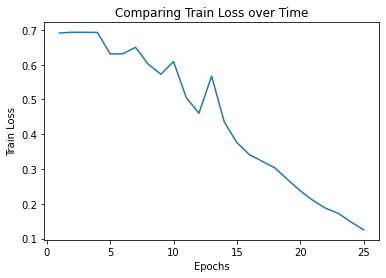

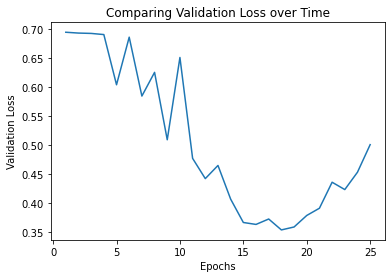

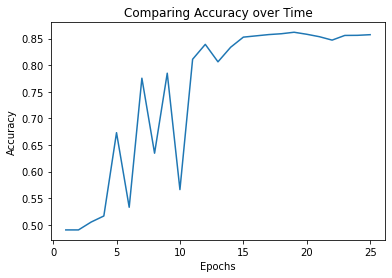

In [ ]:
lstm_classifier = LSTMClassifier()

loss_fn = F.binary_cross_entropy
optimizer = Adam(lstm_classifier.parameters(), lr=1e-3)

lstm_classifier.to(device)

lstm_valid_losses = []
lstm_valid_accs = []
lstm_train_losses = []
epochs = 25
TrainModel(lstm_classifier, loss_fn, optimizer, train_loader, test_loader, lstm_valid_losses, lstm_valid_accs, lstm_train_losses, epochs)
PlotOutput(lstm_train_losses, 'Train Loss', epochs)
PlotOutput(lstm_valid_losses, "Validation Loss", epochs)
PlotOutput(lstm_valid_accs, "Accuracy", epochs)
# torch.save(lstm_classifier, PATH + 'models/lstm.model')

### Train Bi-LSTM

Epoch : 1


100%|█████████████████████████████████████████████████| 313/313 [00:04<00:00, 64.78it/s]


Train Loss : 0.589
Valid Loss : 0.455
Valid Acc  : 0.810
Epoch : 2


100%|█████████████████████████████████████████████████| 313/313 [00:05<00:00, 62.51it/s]


Train Loss : 0.430
Valid Loss : 0.385
Valid Acc  : 0.840
Epoch : 3


100%|█████████████████████████████████████████████████| 313/313 [00:04<00:00, 68.44it/s]


Train Loss : 0.372
Valid Loss : 0.352
Valid Acc  : 0.856
Epoch : 4


100%|█████████████████████████████████████████████████| 313/313 [00:04<00:00, 67.21it/s]


Train Loss : 0.341
Valid Loss : 0.358
Valid Acc  : 0.853
Epoch : 5


100%|█████████████████████████████████████████████████| 313/313 [00:04<00:00, 64.71it/s]


Train Loss : 0.309
Valid Loss : 0.351
Valid Acc  : 0.865
Epoch : 6


100%|█████████████████████████████████████████████████| 313/313 [00:04<00:00, 63.08it/s]


Train Loss : 0.279
Valid Loss : 0.373
Valid Acc  : 0.860
Epoch : 7


100%|█████████████████████████████████████████████████| 313/313 [00:05<00:00, 58.92it/s]


Train Loss : 0.250
Valid Loss : 0.394
Valid Acc  : 0.831
Epoch : 8


100%|█████████████████████████████████████████████████| 313/313 [00:04<00:00, 73.15it/s]


Train Loss : 0.217
Valid Loss : 0.422
Valid Acc  : 0.864
Epoch : 9


100%|█████████████████████████████████████████████████| 313/313 [00:04<00:00, 71.31it/s]


Train Loss : 0.201
Valid Loss : 0.406
Valid Acc  : 0.866
Epoch : 10


100%|█████████████████████████████████████████████████| 313/313 [00:04<00:00, 75.11it/s]


Train Loss : 0.170
Valid Loss : 0.512
Valid Acc  : 0.828


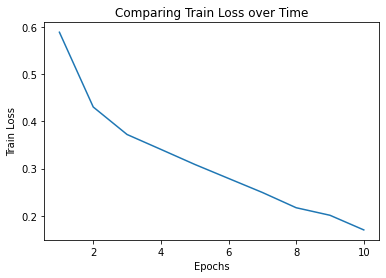

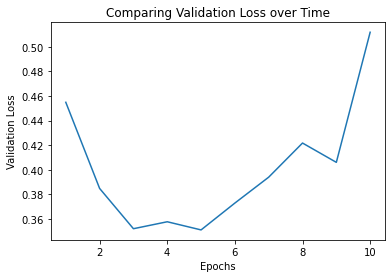

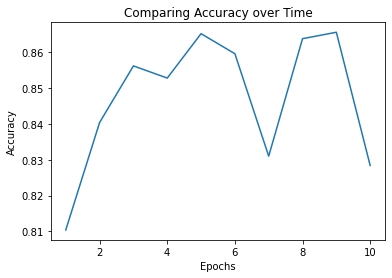

In [ ]:
bilstm_classifier = BiLSTMClassifier()

loss_fn = F.binary_cross_entropy
optimizer = Adam(bilstm_classifier.parameters(), lr=1e-3)

bilstm_classifier.to(device)

bilstm_valid_losses = []
bilstm_valid_accs = []
bilstm_train_losses = []
epochs = 10
TrainModel(bilstm_classifier, loss_fn, optimizer, train_loader, test_loader, bilstm_valid_losses, bilstm_valid_accs, bilstm_train_losses, epochs)
PlotOutput(bilstm_train_losses, 'Train Loss', epochs)
PlotOutput(bilstm_valid_losses, "Validation Loss", epochs)
PlotOutput(bilstm_valid_accs, "Accuracy", epochs)
# torch.save(bilstm_classifier, PATH + 'models/bilstm.model')

### Train GRU

Epoch : 1


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.20it/s]


Train Loss : 0.657
Valid Loss : 0.621
Valid Acc  : 0.665
Epoch : 2


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.76it/s]


Train Loss : 0.640
Valid Loss : 0.622
Valid Acc  : 0.669
Epoch : 3


100%|█████████████████████████████████████████████████| 313/313 [00:04<00:00, 64.32it/s]


Train Loss : 0.679
Valid Loss : 0.688
Valid Acc  : 0.525
Epoch : 4


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 90.57it/s]


Train Loss : 0.598
Valid Loss : 0.418
Valid Acc  : 0.836
Epoch : 5


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.69it/s]


Train Loss : 0.387
Valid Loss : 0.353
Valid Acc  : 0.858
Epoch : 6


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 91.07it/s]


Train Loss : 0.333
Valid Loss : 0.343
Valid Acc  : 0.862
Epoch : 7


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 82.39it/s]


Train Loss : 0.304
Valid Loss : 0.333
Valid Acc  : 0.865
Epoch : 8


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 83.82it/s]


Train Loss : 0.275
Valid Loss : 0.367
Valid Acc  : 0.856
Epoch : 9


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 88.74it/s]


Train Loss : 0.246
Valid Loss : 0.336
Valid Acc  : 0.871
Epoch : 10


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 93.27it/s]


Train Loss : 0.216
Valid Loss : 0.358
Valid Acc  : 0.874


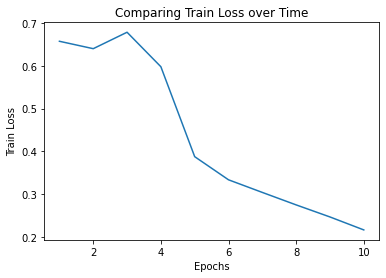

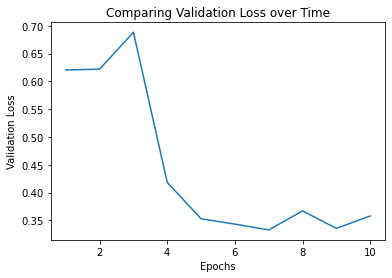

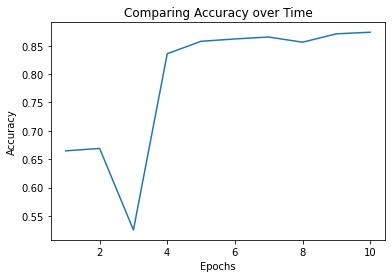

In [ ]:
gru_classifier = GRUClassifier()

loss_fn = F.binary_cross_entropy
optimizer = Adam(gru_classifier.parameters(), lr=1e-3)

gru_classifier.to(device)

gru_valid_losses = []
gru_valid_accs = []
gru_train_losses = []
epochs = 10
TrainModel(gru_classifier, loss_fn, optimizer, train_loader, test_loader, gru_valid_losses, gru_valid_accs, gru_train_losses, epochs)
PlotOutput(gru_train_losses, 'Train Loss', epochs)
PlotOutput(gru_valid_losses, "Validation Loss", epochs)
PlotOutput(gru_valid_accs, "Accuracy", epochs)


### Train CNN

Epoch : 1


100%|█████████████████████████████████████████████████| 313/313 [00:05<00:00, 55.82it/s]


Train Loss : 0.630
Valid Loss : 0.543
Valid Acc  : 0.773
Epoch : 2


100%|█████████████████████████████████████████████████| 313/313 [00:04<00:00, 62.90it/s]


Train Loss : 0.500
Valid Loss : 0.470
Valid Acc  : 0.797
Epoch : 3


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.47it/s]


Train Loss : 0.433
Valid Loss : 0.445
Valid Acc  : 0.799
Epoch : 4


100%|█████████████████████████████████████████████████| 313/313 [00:04<00:00, 73.77it/s]


Train Loss : 0.391
Valid Loss : 0.435
Valid Acc  : 0.800
Epoch : 5


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 83.16it/s]


Train Loss : 0.359
Valid Loss : 0.429
Valid Acc  : 0.803
Epoch : 6


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 79.49it/s]


Train Loss : 0.332
Valid Loss : 0.426
Valid Acc  : 0.806
Epoch : 7


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 79.06it/s]


Train Loss : 0.308
Valid Loss : 0.424
Valid Acc  : 0.809
Epoch : 8


100%|█████████████████████████████████████████████████| 313/313 [00:04<00:00, 77.86it/s]


Train Loss : 0.287
Valid Loss : 0.424
Valid Acc  : 0.810
Epoch : 9


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 79.87it/s]


Train Loss : 0.267
Valid Loss : 0.424
Valid Acc  : 0.810
Epoch : 10


100%|█████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.50it/s]


Train Loss : 0.249
Valid Loss : 0.426
Valid Acc  : 0.811


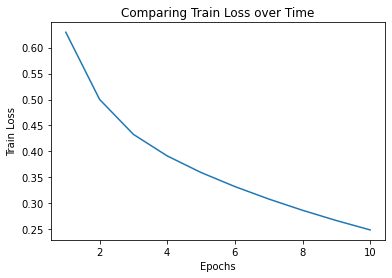

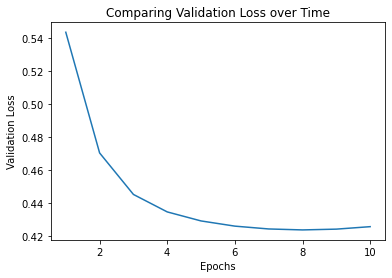

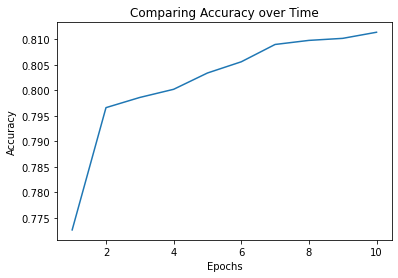

In [ ]:
cnn_classifier = ConvNN()

loss_fn = F.binary_cross_entropy
optimizer = Adam(cnn_classifier.parameters(), lr=1e-4)

cnn_classifier.to(device)

cnn_valid_losses = []
cnn_valid_accs = []
cnn_train_losses = []
epochs = 10
TrainModel(cnn_classifier, loss_fn, optimizer, train_loader, test_loader, cnn_valid_losses, cnn_valid_accs, cnn_train_losses, epochs=10)
PlotOutput(cnn_train_losses, 'Train Loss', epochs)
PlotOutput(cnn_valid_losses, "Validation Loss", epochs)
PlotOutput(cnn_valid_accs, "Accuracy", epochs)


# Discussion

The accuracy levels for each of the word embeddings and models are compared to determine which word embeddings and model produced the highest accuracy. In addition, an analysis of the actual outputs along with any possible errors are also made.

*   **Strengths**
  The GRU-based system reached a peak trained validation accuracy of 87.7%, with similar performance (86.88%) realised when submitted to Kaggle and tested against the hidden test data, meaning that it is quite robust when given input on which it was not trained. Given the wide variation in the content of reviews within the dataset, this should indicate that the network would be effective at analysing reviews in a live context, wherein it is tasked with analysing the sentiment of newly submitted user-reviews on the IMDb site.
*  **Weaknesses**
  Since the system's pre-processing steps include removing stopwords, words which are key to the sentiment of the review may unintentionally be omitted. This might include converting: "This movie is not great" to "movie great", which may cause the network to misinterpret the sentiment of the original text. Our models also tended to overfit a bit too.

*   **Limitations**
  Whilst using Google Colab provided an easy platform for sharing and running code within the browser, there was a limit on the maximum RAM available, resulting in us to reduce the review length which reduced our accuracy as accuracy improves with a larger review length. In addition, GPU availability was also quite limited which significantly increased training time. Finally, other Kaggle submissions also utilised additional data compared to what we used. As a result, our maximum accuracy cap is lower than those submissions.

*   **Possible Future Work**
With additional time for experimentation, the team could optimise the GRU network hyperparameters to fully realise the performance benefits of the BERT-generated embeddings, since it is believed that the project time-constraints prevented the GRU network from being optimally tuned to use these embeddings. Further recommendations for future work include the application of the network to reviews from other sources, such as those for retail products, music or books, as well as the prediction of other review metrics such as their associated numerical score.







## Word embeddings comparison

As there are many word embeddings available, we decided to experiment to see how they would affect the performance of the model. GloVe was chosen as the final word embedding as it produced the highest accuracy after experimentation and hypertuning.   

On a side note, while the performance of the tested networks using BERT embeddings failed to exceed that of networks using GloVe, it is believed that this is a result of an inability to sufficiently tune the BERT-embedding networks within the project timeframe. The BERT embeddings were of length 768, as compared to those generated by GloVe, which were of length 300. This discrepancy meant that networks which had originally been tuned for GloVe needed to be re-tuned for a significantly larger embedding size, and hence optimal performance using BERT embeddings may not have been realised during testing.



## Model performance comparison

In [ ]:
model_performance = []
model_performance.append(['Linear', max(linear_valid_accs)])
model_performance.append(['LSTM', max(lstm_valid_accs)])
model_performance.append(['BiLSTM', max(bilstm_valid_accs)])
model_performance.append(['GRU', max(gru_valid_accs)])
model_performance.append(['CNN', max(cnn_valid_accs)])
model_performance_df = pd.DataFrame(model_performance, columns=["Model", "Accuracy"])

display(HTML(model_performance_df.to_html(index=False)))

Model,Accuracy
Linear,0.8080
LSTM,0.8620
BiLSTM,0.8656
GRU,0.8738
CNN,0.8114


## Error analysis (comparison of linear and LSTM results)

Attempt to identify trends or patterns in how these models are classifying data.

Prepare subset of whole dataset for comparison

In [ ]:
shortLabeledTrainData = labeledTrainData.head(1000)

shortLabeledTrainData['ProcessedReview'] = shortLabeledTrainData['review'].apply(lambda review: review_to_wordlist(review, remove_stopwords=True, lemmatise=True))

def convert(reviews, sentiments):
    # For each review, add filler (empty) strings to the list of tokenised words if it is shorter than MAX_REVIEW_LENGTH
    padded_reviews = [tokens + [""] * (MAX_REVIEW_LENGTH-len(tokens)) if len(tokens)<MAX_REVIEW_LENGTH else tokens[:MAX_REVIEW_LENGTH] for tokens in reviews]
    reviews_tensor = torch.zeros(len(reviews), MAX_REVIEW_LENGTH, EMBED_LEN)

    # Convert token list to list of word vectors
    for i, tokens in enumerate(padded_reviews):
        reviews_tensor[i] = global_vectors.get_vecs_by_tokens(tokens)
    x = reviews_tensor

    y_tensor = torch.tensor(sentiments.values, dtype=torch.float32)
    y = y_tensor.reshape(y_tensor.shape[0], -1)

    return x, y

short_X, short_Y = convert(shortLabeledTrainData['ProcessedReview'], shortLabeledTrainData['sentiment'])

short_Y = pd.Series(short_Y.detach().numpy().squeeze())

flattened_short_X = torch.reshape(short_X, (short_X.shape[0], short_X.shape[1] * short_X.shape[2]))

embed_classifier.to('cpu')
lstm_classifier.to('cpu')

linear_results = pd.Series(embed_classifier(flattened_short_X).detach().numpy().squeeze())
linear_results = (linear_results >= 0.5).astype(float)

lstm_results = pd.Series(lstm_classifier(short_X).detach().numpy().squeeze())
lstm_results = (lstm_results >= 0.5).astype(float)

embed_classifier.to(device)
lstm_classifier.to(device)

C:\Users\erich\anaconda3\envs\yolov7\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\erich\AppData\Local\Temp\ipykernel_32788\2234206415.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shortLabeledTrainData['ProcessedReview'] = shortLabeledTrainData['review'].apply(lambda review: review_to_wordlist(review, remove_stopwords=True, lemmatise=True))


LSTMClassifier(
  (seq): Sequential(
    (0): LSTM(300, 128, batch_first=True)
    (1): extract_output_lstm()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=20, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=20, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

Both LSTM and Linear wrong

In [ ]:
count = 0

for i in range(len(short_X)):
    if count > 3:
        break
    if linear_results[i].item() != short_Y[i].item() and lstm_results[i].item() != short_Y[i].item():
        print('---------------')
        print('linear:', 'Positive' if linear_results[i].item() == 1 else 'Negative')
        print('lstm:', 'Positive' if lstm_results[i].item() == 1 else 'Negative')
        print('true:', 'Positive' if short_Y[i].item() == 1 else 'Negative')
        print(textwrap.fill(BeautifulSoup(shortLabeledTrainData['review'][i]).get_text(), 100))
        count += 1

---------------
linear: Negative
lstm: Negative
true: Positive
"Superbly trashy and wondrously unpretentious 80's exploitation, hooray! The pre-credits opening
sequences somewhat give the false impression that we're dealing with a serious and harrowing drama,
but you need not fear because barely ten minutes later we're up until our necks in nonsensical
chainsaw battles, rough fist-fights, lurid dialogs and gratuitous nudity! Bo and Ingrid are two
orphaned siblings with an unusually close and even slightly perverted relationship. Can you imagine
playfully ripping off the towel that covers your sister's naked body and then stare at her unshaven
genitals for several whole minutes? Well, Bo does that to his sister and, judging by her dubbed
laughter, she doesn't mind at all. Sick, dude! Anyway, as kids they fled from Russia with their
parents, but nasty soldiers brutally slaughtered mommy and daddy. A friendly smuggler took custody
over them, however, and even raised and trained Bo and Ing

LSTM right but Linear wrong

In [ ]:
count = 0

for i in range(len(short_X)):
    if count > 3:
        break
    if linear_results[i].item() != short_Y[i].item() and lstm_results[i].item() == short_Y[i].item():
        print('---------------')
        print('linear:', 'Positive' if linear_results[i].item() == 1 else 'Negative')
        print('lstm:', 'Positive' if lstm_results[i].item() == 1 else 'Negative')
        print('true:', 'Positive' if short_Y[i].item() == 1 else 'Negative')
        print(textwrap.fill(BeautifulSoup(shortLabeledTrainData['review'][i]).get_text(), 100))
        count += 1

---------------
linear: Negative
lstm: Positive
true: Positive
"Simon Pegg plays a rude crude and often out of control celebrity journalist who is brought from
England to work for a big American magazine. Of course his winning ways create all sorts of
complications. Amusing fact based comedy that co stars Kristen Dunst (looking rather grown up),
Danny Huston, and Jeff Bridges. It works primarily because we like Simon Pegg despite his bad
behavior. We completely understand why Kristen Dunst continues to talk to him despite his frequent
screw ups. I liked the film. Its not the be all and end all but it was a nice way to cap off an
evening of sitting on the couch watching movies.7 out of 10"
---------------
linear: Negative
lstm: Positive
true: Positive
"WARNING: POSSIBLE SPOILERS (but not really - keep reading). Ahhh, there are so many reasons to
become utterly addicted to this spoof gem that I won't have room to list them all. The opening
credits set the playful scene with kitsch late 1

Linear right but LSTM wrong

In [ ]:
count = 0

for i in range(len(short_X)):
    if count > 3:
        break
    if linear_results[i].item() == short_Y[i].item() and lstm_results[i].item() != short_Y[i].item():
        print('---------------')
        print('linear:', 'Positive' if linear_results[i].item() == 1 else 'Negative')
        print('lstm:', 'Positive' if lstm_results[i].item() == 1 else 'Negative')
        print('true:', 'Positive' if short_Y[i].item() == 1 else 'Negative')
        print(textwrap.fill(BeautifulSoup(shortLabeledTrainData['review'][i]).get_text(), 100))
        count += 1

---------------
linear: Positive
lstm: Negative
true: Positive
"Eva (Hedy Lamarr) has just got married with an older man and in the honeymoon, she realizes that
her husband does not desire her. Her disappointment with the marriage and the privation of love,
makes Eva returning to her father's home in a farm, leaving her husband. One afternoon, while
bathing in a lake, her horse escapes with her clothes and an young worker retrieves and gives them
back to Eva. They fall in love for each other and become lovers. Later, her husband misses her and
tries to have Eva back home. Eva refuses, and fortune leads the trio to the same place, ending the
affair in a tragic way. I have just watched \"Extase\" for the first time, and the first remark I
have is relative to the horrible quality of the VHS released in Brazil by the Brazilian distributor
Video Network: the movie has only 75 minutes running time, and it seems that it was used different
reels of film. There are some parts totally damaged, a

Both LSTM and Linear correct

In [ ]:
count = 0

for i in range(len(short_X)):
    if count > 3:
        break
    if linear_results[i].item() == short_Y[i].item() and lstm_results[i].item() == short_Y[i].item():
        print('---------------')
        print('linear:', 'Positive' if linear_results[i].item() == 1 else 'Negative')
        print('lstm:', 'Positive' if lstm_results[i].item() == 1 else 'Negative')
        print('true:', 'Positive' if short_Y[i].item() == 1 else 'Negative')
        print(textwrap.fill(BeautifulSoup(shortLabeledTrainData['review'][i]).get_text(), 100))
        count += 1

---------------
linear: Positive
lstm: Positive
true: Positive
"With all this stuff going down at the moment with MJ i've started listening to his music, watching
the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want
to get a certain insight into this guy who i thought was really cool in the eighties just to maybe
make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film
which i remember going to see at the cinema when it was originally released. Some of it has subtle
messages about MJ's feeling towards the press and also the obvious message of drugs are bad
m'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely
like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist
for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for
the fans which if true is really nice of him.The actu